In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from DeepTaxonNet import DeepTaxonNet
import argparse
import utils

from sklearn.mixture import GaussianMixture

import os
import sys

In [3]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('fashion-mnist', 128, False)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [9]:
def t_sne(model, test_loader, device, epoch):
    all_latent = []
    all_labels = []
    all_pcx = []
    pis = []
    mu_c = None
    for i, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            data = data.to(device)
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
            all_latent.append(latent)
            all_labels.append(target)

            _, recon_loss, kl1, kl2, H, pcx, pi, sym_kl = model(data)
            all_pcx.append(pcx)
            # pis.append(pi)
            pis = pi.cpu().numpy()


            if i == 2:
                break
            mu_c = model.gmm_params()[1]
            centroids = model.decode(mu_c)
            centroids = centroids.view(-1, 28, 28).detach().cpu().numpy()
            # plot 8 * 8 centroids 
    plt.figure(figsize=(8, 8))
    for i in range(len(centroids)):
        plt.subplot(16, 16, i+1)
        plt.imshow(centroids[i], cmap='gray')
        plt.axis('off')
    plt.savefig('viz_out/vade_muc.png')
    plt.close()
    # plt.show()

    # plot entropy at each layer
    num_layers = len(H)
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))
    fig = plt.figure(figsize=(5, 5))
    for i, entropy in enumerate(H):
        entropy = entropy.cpu().numpy()
        plt.scatter(np.arange(entropy.shape[0]), entropy, alpha=0.5, color=colors[i], label=f'layer {i}')
    plt.savefig(f'viz_out/vade_entropy.png')
    plt.legend()
    plt.close()

    num_layers = len(sym_kl)
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))
    fig = plt.figure(figsize=(5, 5))
    for i, dkl in enumerate(sym_kl):
        dkl = dkl.cpu().numpy()
        plt.scatter(np.arange(dkl.shape[0]), dkl, alpha=0.5, color=colors[i], label=f'layer {i}')
    plt.legend()
    plt.savefig(f'viz_out/vade_sym_kl.png')
    plt.close()




    all_latent = torch.cat(all_latent, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_latent = all_latent.cpu().numpy()
    # concate with mu_c
    all_latent = np.concatenate((all_latent, mu_c.detach().cpu().numpy()), axis=0)
    all_labels = all_labels.cpu().numpy()

    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(all_latent)
    # plt.figure(figsize=(5, 5))
    # subplots, 1 by 3
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].scatter(tsne_results[:len(all_labels), 0], tsne_results[:len(all_labels), 1], c=all_labels, cmap='tab10', s=10)
    # axs[0].colorbar()
    axs[0].scatter(tsne_results[len(all_labels):, 0], tsne_results[len(all_labels):, 1], c='black', s=50, marker='x')
    # plt.colorbar()


    # subplot 2, pcx 
    pcx = torch.cat(all_pcx, dim=0) # batch_size, n_classes
    pcx = pcx.cpu().numpy()
    # plot line plot for each data point and color by label
    axs[1].plot(pcx[:len(all_labels), :].T, c='blue', alpha=0.003)
    # multiple bars
    # for i in range(pcx.shape[0]):
        # axs[1].bar(np.arange(pcx.shape[1]), pcx[i], color='blue', alpha=0.005)

    # subplot 3, pi, shape (n_classes,)
    axs[2].plot(pis.T, c='red', alpha=0.5)
    # axs[2].bar(np.arange(pis.shape[0]), pis, color='red', alpha=0.5)

    # plt.savefig(f'viz_out/vade{epoch}.png')
    # plt.savefig(f'viz_out/vade_tree_{epoch}.png')
    plt.savefig(f'viz_out/vade_tree_0.png')

    plt.close()






In [28]:
n_layers=5
# model = DeepTaxonNet(
#     n_layers=n_layers,
#     enc_hidden_dim=128,
#     dec_hidden_dim=128,
#     input_dim=3*32*32,
#     latent_dim=128,
#     encoder_name='mlp',
#     decoder_name='mlp',
# ).to(device)

# model = DeepTaxonNet(
#     n_layers=n_layers,
#     enc_hidden_dim=64*8*8,
#     dec_hidden_dim=(64,8,8),
#     input_dim=3*32*32,
#     latent_dim=768,
#     encoder_name='resnet18_light',
#     decoder_name='resnet18_light',
#     kl1_weight=1
# ).to(device)

model = DeepTaxonNet(
    n_layers=n_layers,
    enc_hidden_dim=32*3*3,
    dec_hidden_dim=(32,3,3),
    input_dim=1*28*28,
    latent_dim=10,
    encoder_name='mnist',
    decoder_name='mnist',
    kl1_weight=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-3)
# add a scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.09)
noise_scheduler = utils.NoiseScheduler(1000, 1.0, 0.001)
# pretrain
optimizer_pretrain = optim.AdamW(
    list(model.encoder.parameters()) + 
    list(model.decoder.parameters()) +
    list(model.fc_mu.parameters()),
    # list(model.fc_logvar.parameters()),
    lr=1e-3,
)
utils.pretrain(model, train_loader, optimizer_pretrain, 0, device) 

# train 
epochs = 150
for epoch in range(epochs):
    model.train()
    for i, (data, _) in enumerate(train_loader):
        data = data.to(device)
        #---------ELBO loss------------#
        optimizer.zero_grad()
        # model.noise_strength = noise_scheduler.get_noise()
        if epoch < 10:
            model.noise_strength = 0.0
        elif epoch < 30:
            model.noise_strength = 0.1
        elif epoch < 50:
            model.noise_strength = 0.2


        loss, recon_loss, kl1, kl2, _, _, _, _ = model(data)
        # loss, recloss, kl1, _ = model.vae_forward(data)
        # print('loss:', loss.item(), 'recloss:', recloss.item(), 'kl1:', kl1.item(), 'kl2:', kl2.item())
        # break
        # print('kl1:', kl1.item(), 'recloss:', recloss.item())
        #----------------------------#
        loss.backward()
        optimizer.step()
        # noise_scheduler.step()
        # if i % 100 == 0:
    print('Epoch:', epoch, 'Loss:', loss.item())
    scheduler.step()

    # testing
    # utils.linear_probing(model, 10, mnist_train_loader, mnist_test_loader, 1e-3, 1, device)
    # if epoch==9:
        # all_latent, all_labels, pcx, pis, centroid_list, H = utils.get_latent(model, test_loader, device)
    
    if epoch % 10 == 1:
        model.eval()
        t_sne(model, test_loader, device, epoch)

0it [00:00, ?it/s]


Epoch: 0 Loss: 34.4713134765625
Epoch: 1 Loss: 31.157854080200195


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/multiprocessing/queues.py", line 257, in _feed
    reader_close()
    ~~~~~~~~~~~~^^
  File "/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/multiprocessing/connection.py", line 178, in close
    self._close()
    ~~~~~~~~~~~^^
  File "/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
    ~~~~~~^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  Fil

Epoch: 2 Loss: 30.5672664642334
Epoch: 3 Loss: 29.8193359375
Epoch: 4 Loss: 28.07648277282715
Epoch: 5 Loss: 27.74984359741211
Epoch: 6 Loss: 26.906105041503906
Epoch: 7 Loss: 27.419883728027344
Epoch: 8 Loss: 26.137619018554688
Epoch: 9 Loss: 24.06068229675293
Epoch: 10 Loss: 26.516172409057617
Epoch: 11 Loss: 26.690282821655273


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 12 Loss: 25.25848388671875
Epoch: 13 Loss: 24.716278076171875
Epoch: 14 Loss: 25.36277961730957
Epoch: 15 Loss: 26.747615814208984
Epoch: 16 Loss: 26.34971046447754
Epoch: 17 Loss: 26.830495834350586
Epoch: 18 Loss: 26.375314712524414
Epoch: 19 Loss: 26.001663208007812
Epoch: 20 Loss: 24.967458724975586
Epoch: 21 Loss: 25.757102966308594


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 22 Loss: 27.53972816467285
Epoch: 23 Loss: 27.39682960510254
Epoch: 24 Loss: 25.824974060058594
Epoch: 25 Loss: 24.719762802124023
Epoch: 26 Loss: 25.506359100341797
Epoch: 27 Loss: 23.779497146606445
Epoch: 28 Loss: 24.218955993652344
Epoch: 29 Loss: 26.70755958557129
Epoch: 30 Loss: 25.007776260375977
Epoch: 31 Loss: 24.983043670654297


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 32 Loss: 25.0220947265625
Epoch: 33 Loss: 24.690635681152344
Epoch: 34 Loss: 25.13143539428711
Epoch: 35 Loss: 24.964481353759766
Epoch: 36 Loss: 22.674606323242188
Epoch: 37 Loss: 25.388795852661133
Epoch: 38 Loss: 24.205524444580078
Epoch: 39 Loss: 26.3404598236084
Epoch: 40 Loss: 25.783912658691406
Epoch: 41 Loss: 24.46017837524414


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 42 Loss: 27.115747451782227
Epoch: 43 Loss: 25.75750732421875
Epoch: 44 Loss: 25.2113037109375
Epoch: 45 Loss: 24.885107040405273
Epoch: 46 Loss: 25.917585372924805
Epoch: 47 Loss: 25.420726776123047
Epoch: 48 Loss: 25.21263885498047
Epoch: 49 Loss: 25.413171768188477
Epoch: 50 Loss: 24.54340934753418
Epoch: 51 Loss: 24.46132469177246


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 52 Loss: 24.36490249633789
Epoch: 53 Loss: 23.494295120239258
Epoch: 54 Loss: 24.059843063354492
Epoch: 55 Loss: 24.076814651489258
Epoch: 56 Loss: 23.0784912109375
Epoch: 57 Loss: 25.09775733947754
Epoch: 58 Loss: 25.770111083984375
Epoch: 59 Loss: 25.14197540283203
Epoch: 60 Loss: 25.50002670288086
Epoch: 61 Loss: 25.220327377319336


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 62 Loss: 23.181608200073242
Epoch: 63 Loss: 26.48310661315918
Epoch: 64 Loss: 24.908723831176758
Epoch: 65 Loss: 23.50629997253418
Epoch: 66 Loss: 24.763643264770508
Epoch: 67 Loss: 24.653358459472656
Epoch: 68 Loss: 24.175806045532227
Epoch: 69 Loss: 24.438920974731445
Epoch: 70 Loss: 22.698137283325195
Epoch: 71 Loss: 23.537487030029297


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 72 Loss: 25.34615135192871
Epoch: 73 Loss: 24.576814651489258
Epoch: 74 Loss: 25.785825729370117
Epoch: 75 Loss: 23.560304641723633
Epoch: 76 Loss: 24.95872688293457
Epoch: 77 Loss: 24.6352481842041
Epoch: 78 Loss: 23.78618812561035
Epoch: 79 Loss: 24.3067684173584
Epoch: 80 Loss: 26.130023956298828
Epoch: 81 Loss: 23.56346321105957


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 82 Loss: 24.337833404541016
Epoch: 83 Loss: 25.110477447509766
Epoch: 84 Loss: 24.844966888427734
Epoch: 85 Loss: 25.20237922668457
Epoch: 86 Loss: 24.232065200805664
Epoch: 87 Loss: 23.68858528137207
Epoch: 88 Loss: 24.672794342041016
Epoch: 89 Loss: 23.568330764770508
Epoch: 90 Loss: 23.9532413482666
Epoch: 91 Loss: 24.04780387878418


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 92 Loss: 24.10245132446289
Epoch: 93 Loss: 24.77886390686035
Epoch: 94 Loss: 24.614896774291992
Epoch: 95 Loss: 25.097299575805664
Epoch: 96 Loss: 26.205562591552734
Epoch: 97 Loss: 24.17096519470215
Epoch: 98 Loss: 24.872156143188477
Epoch: 99 Loss: 25.519939422607422
Epoch: 100 Loss: 24.207317352294922
Epoch: 101 Loss: 23.275981903076172


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 102 Loss: 26.46133804321289
Epoch: 103 Loss: 23.02611541748047
Epoch: 104 Loss: 25.301660537719727
Epoch: 105 Loss: 23.668115615844727
Epoch: 106 Loss: 25.663410186767578
Epoch: 107 Loss: 24.77699851989746
Epoch: 108 Loss: 24.60903549194336
Epoch: 109 Loss: 23.322357177734375
Epoch: 110 Loss: 25.947227478027344
Epoch: 111 Loss: 23.466079711914062


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 112 Loss: 25.341073989868164
Epoch: 113 Loss: 25.112472534179688
Epoch: 114 Loss: 25.309757232666016
Epoch: 115 Loss: 24.347238540649414
Epoch: 116 Loss: 24.78881072998047
Epoch: 117 Loss: 25.234302520751953
Epoch: 118 Loss: 23.589828491210938
Epoch: 119 Loss: 26.219898223876953
Epoch: 120 Loss: 25.129465103149414
Epoch: 121 Loss: 24.381608963012695


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 122 Loss: 23.430950164794922
Epoch: 123 Loss: 25.237911224365234
Epoch: 124 Loss: 26.259597778320312
Epoch: 125 Loss: 22.613357543945312
Epoch: 126 Loss: 23.69361686706543
Epoch: 127 Loss: 24.81218147277832
Epoch: 128 Loss: 24.689517974853516
Epoch: 129 Loss: 24.668577194213867
Epoch: 130 Loss: 24.946395874023438
Epoch: 131 Loss: 23.943225860595703


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 132 Loss: 23.561941146850586
Epoch: 133 Loss: 24.468643188476562
Epoch: 134 Loss: 25.715044021606445
Epoch: 135 Loss: 25.182523727416992
Epoch: 136 Loss: 25.01569938659668
Epoch: 137 Loss: 24.229339599609375
Epoch: 138 Loss: 23.57831573486328
Epoch: 139 Loss: 24.770856857299805
Epoch: 140 Loss: 23.23456382751465
Epoch: 141 Loss: 25.263084411621094


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 142 Loss: 24.867429733276367
Epoch: 143 Loss: 24.9968204498291
Epoch: 144 Loss: 23.43936538696289
Epoch: 145 Loss: 24.754520416259766
Epoch: 146 Loss: 23.772932052612305
Epoch: 147 Loss: 25.171512603759766
Epoch: 148 Loss: 23.583831787109375
Epoch: 149 Loss: 24.08500862121582


In [29]:
F.sigmoid(model.layers[-1].cluster_weight)

tensor([[0.5025]], device='cuda:0', grad_fn=<SigmoidBackward0>)

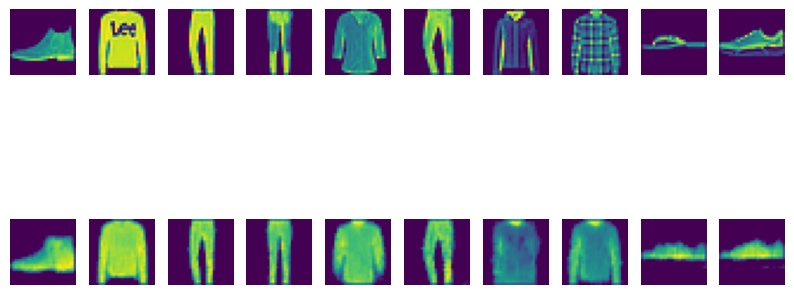

In [30]:
# test image reconstruction
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        latent, logvar = model.encode(data)
        latent = model.reparameterize(latent, logvar)
        x_hat = model.decode(latent)
        # latent = model.encoder(data)
        # x_hat = model.decoder_raw(latent)
        break

# plot original and reconstructed images
# original images
data = data.view(-1, 1, 28, 28).cpu().numpy()[:10]
# reconstructed images
x_hat = x_hat.view(-1, 1, 28, 28).cpu().numpy()[:10]
# plot 10 images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(data[i].transpose(1, 2, 0))
    plt.axis('off')
    plt.subplot(2, 10, i+11)
    plt.imshow(x_hat[i].transpose(1, 2, 0))
    plt.axis('off')

plt.show()

In [34]:
all_latent, all_labels, pcx, pis, centroid_list, H = utils.get_latent(model, test_loader, device)


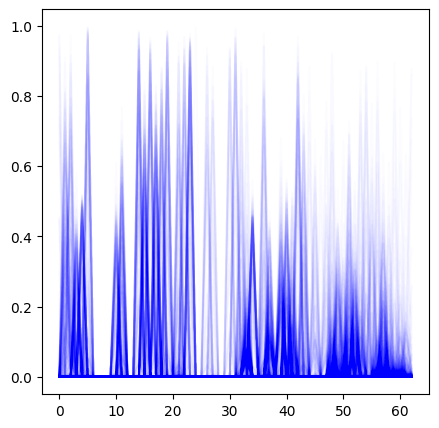

In [48]:
utils.plot_qcx(pcx).show()

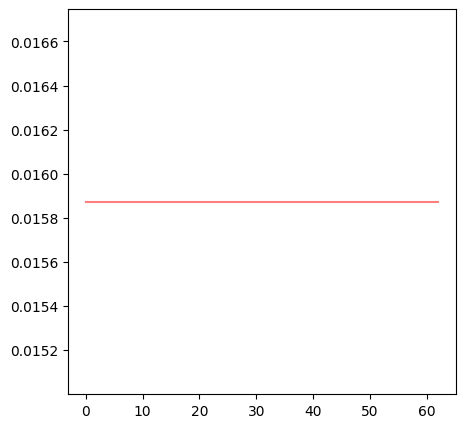

In [49]:
utils.plot_pi(pis).show()

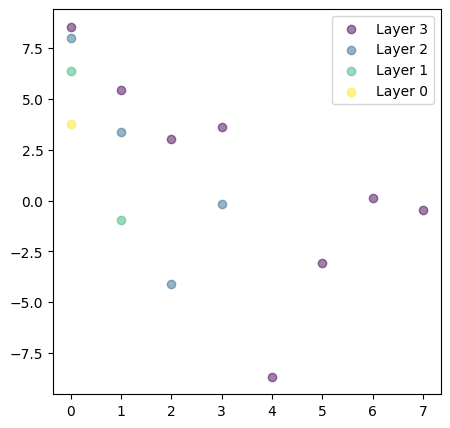

In [121]:
utils.plot_entropy(H).show()

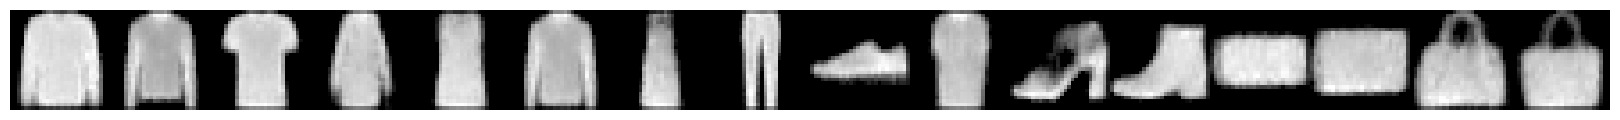

In [37]:
utils.plot_centroids(centroid_list, 4).show()

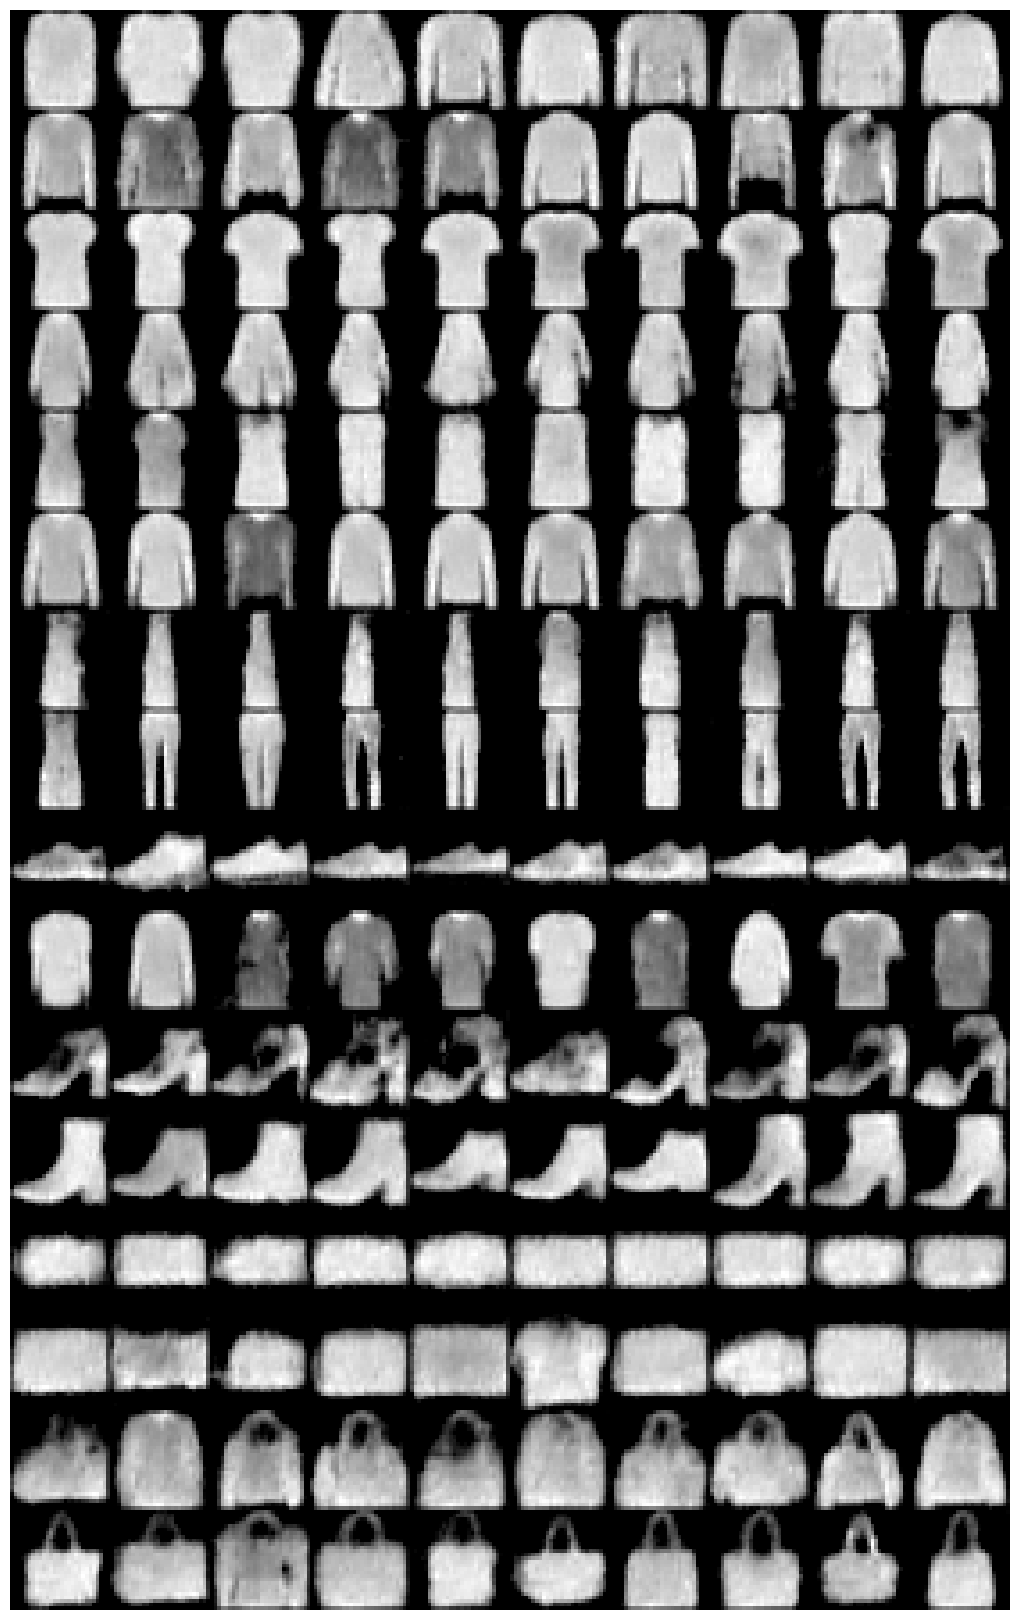

In [50]:
utils.plot_generated_examples(model, 4, 10, device).show()

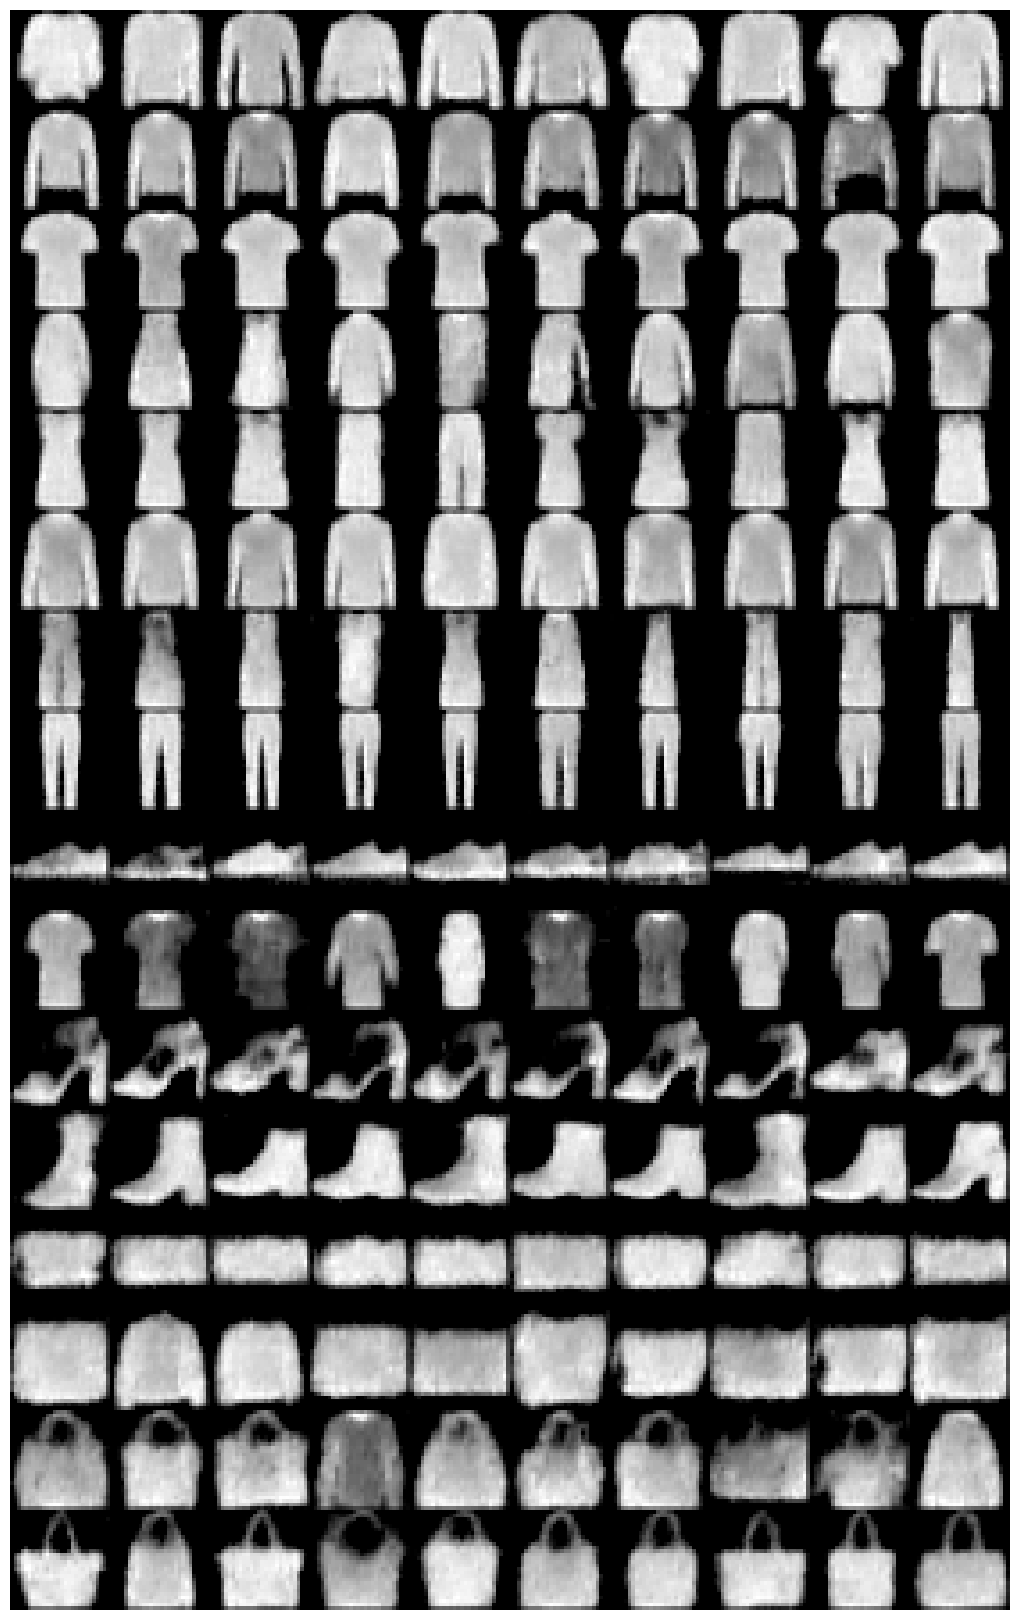

In [45]:
utils.plot_dataset_examples(model, all_latent, pcx, 4, 10, device).show()

In [46]:
# save model
torch.save(model.state_dict(), 'vade_fashion_mnist_tree.pth')

In [33]:
# load model
n_layers=4
model = GMMDeepTaxonNet(n_layers=n_layers, 
                        encoder_shared=True
                        ).to(device)
model.load_state_dict(torch.load('vade_tree.pth'))

<All keys matched successfully>

In [47]:
# linear probing
model.eval()
# freeze model
for param in model.parameters():
    param.requires_grad = False
# add linear layer
classifier = nn.Linear(model.latent_dim, 10).to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-2)
classifier_loss = nn.CrossEntropyLoss()
# train linear layer
epochs = 100

for epoch in range(epochs):
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        #---------ELBO loss------------#
        optimizer.zero_grad()
        with torch.no_grad():
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
        # print('latent:', latent.shape)
        output = classifier(latent)
        loss = classifier_loss(output, target)
        # print('loss:', loss.item(), 'recloss:', recloss.item(), 'kl1:', kl1.item(), 'kl2:', kl2.item())
        # break
        # print('kl1:', kl1.item(), 'kl2:', kl2.item())
        #----------------------------#
        loss.backward()
        classifier_optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())
    # test linear layer
    model.eval()
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
            output = classifier(latent)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print('Accuracy:', correct / total)




Epoch: 0 Loss: 0.8998202681541443
Accuracy: 0.667
Epoch: 1 Loss: 1.2872430086135864
Accuracy: 0.6926
Epoch: 2 Loss: 1.405171513557434
Accuracy: 0.6965
Epoch: 3 Loss: 1.5855112075805664
Accuracy: 0.6858
Epoch: 4 Loss: 1.2203313112258911
Accuracy: 0.7065
Epoch: 5 Loss: 1.446583867073059
Accuracy: 0.6839
Epoch: 6 Loss: 1.772274136543274
Accuracy: 0.6592
Epoch: 7 Loss: 1.6047440767288208
Accuracy: 0.6615
Epoch: 8 Loss: 2.2280385494232178
Accuracy: 0.6723
Epoch: 9 Loss: 2.1089210510253906
Accuracy: 0.6464


KeyboardInterrupt: 

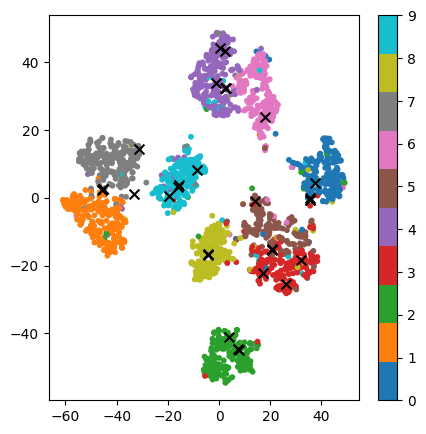

In [9]:
# plot datapoints along with the centroids
all_latent = []
all_labels = []
mu_c = None

with torch.no_grad():
    for i, (data, target) in enumerate(mnist_test_loader):
        data = data.view(-1, 28*28).to(device)
        mu, logvar = model.encode(data)
        latent = model.reparameterize(mu, logvar)
        all_latent.append(latent)
        all_labels.append(target)
        if i == 1:
            break
    mu_c = model.gmm_params()[1].detach().cpu().numpy()
    # mu_c = mu_c[-5:]
    # print(mu_c.shape)


all_latent = torch.cat(all_latent, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_latent = all_latent.cpu().numpy()
# concate with mu_c
all_latent = np.concatenate((all_latent, mu_c), axis=0)


all_labels = all_labels.cpu().numpy()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(all_latent)
plt.figure(figsize=(5, 5))
plt.scatter(tsne_results[:len(all_labels), 0], tsne_results[:len(all_labels), 1], c=all_labels, cmap='tab10', s=10)
plt.colorbar()
plt.scatter(tsne_results[len(all_labels):, 0], tsne_results[len(all_labels):, 1], c='black', s=50, marker='x')


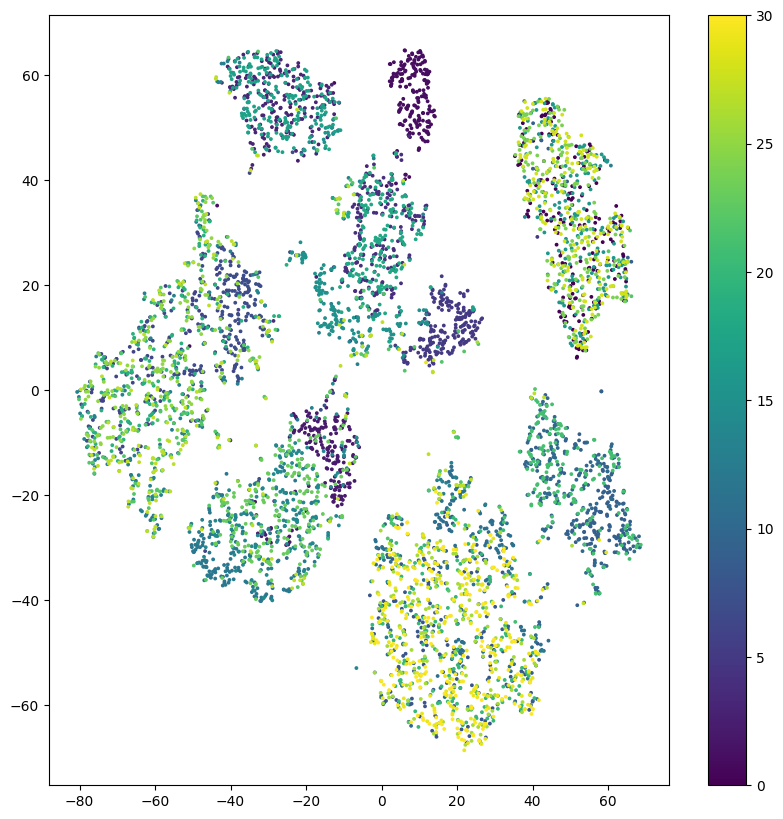

In [62]:
# plot gmms by samplign 100 datapoints at each cluster
# sample 100 points from each cluster
n_samples = 200
with torch.no_grad():
    mu_c = model.gmm_params()[1]
    lagvar_c = model.gmm_params()[2] # n_classes, latent_dim
    # for each cluster, sample 100 points

    labels = torch.arange(len(mu_c)).unsqueeze(1).expand(-1, n_samples).reshape(-1) # n_classes * n_samples
    # print(labels) 

    mu_c = mu_c.unsqueeze(1).repeat(1, n_samples, 1).reshape(-1, model.latent_dim)
    lagvar_c = lagvar_c.unsqueeze(1).repeat(1, n_samples, 1).reshape(-1, model.latent_dim) # n_classes * n_samples, latent_dim
    # print(lagvar_c)
    z = model.reparameterize(mu_c, lagvar_c)

    # tsne
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(z.cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_results[:len(labels), 0], tsne_results[:len(labels), 1], c=labels, cmap='viridis', s=3, marker='o')
    plt.colorbar()
    # plt.savefig('viz_out/vade_gmm.png')
    plt.show()



    # x_hat = model.decode(z)




In [18]:
with torch.no_grad():
    for i, (data, target) in enumerate(mnist_test_loader):
        data = data.view(-1, 28*28).to(device)
        # forward pass
        model(data)
        if i == 0:
            break

torch.Size([30, 32]) torch.Size([30, 32]) torch.Size([30])


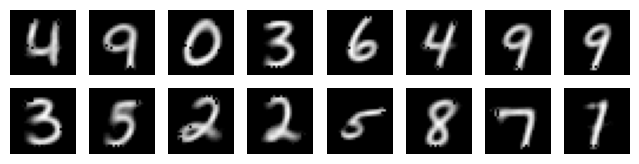

In [14]:
# decode the centroids
at_layer = 5 # root layer
if at_layer == 1:
    centroids = model.gmm_params()[1][-(2**(at_layer)-1):]
else:
    centroids = model.gmm_params()[1][-(2**(at_layer)-1):-(2**(at_layer-1)-1)]

# centroids = torch.zeros(1, 32).to(device)
centroids = model.decode(centroids)
centroids = centroids.view(-1, 28, 28).detach().cpu().numpy()
# plot 8 * 8 centroids 
plt.figure(figsize=(8, 8))
for i in range(len(centroids)):
    plt.subplot(8, 8, i+1)
    plt.imshow(centroids[i], cmap='gray')
    plt.axis('off')
# plt.savefig('viz_out/centroids.png')
plt.show()

In [15]:
# print gaussian p(c) at each layer
pi = model.gmm_params()[0].detach().cpu().numpy()
# print('pi:', pi)
# print pi
n_layers = model.n_layers
for i in range(0, n_layers):
    if i == 0:
        print('Layer:', i, 'p(c):', pi[-(2**(i+1)-1):])
    else:
        print('Layer:', i, 'p(c):', pi[-(2**(i+1)-1):-(2**i-1)])

Layer: 0 p(c): [0.04656837]
Layer: 1 p(c): [0.06666263 0.0200983 ]
Layer: 2 p(c): [6.6571608e-02 5.6309395e-02 1.0357273e-02 4.0336909e-06]
Layer: 3 p(c): [6.3518047e-02 3.2458169e-07 6.6666342e-02 6.2970512e-02 3.6961555e-03
 4.3083075e-02 2.3583591e-02 9.5061499e-05]


In [8]:
import torch
import matplotlib.pyplot as plt

def sample_from_learned_gaussian(model, device, grid_size=8):
    """
    Samples images from the learned Gaussian prior of a VaDE model (with a single Gaussian)
    and displays them in an 8x8 grid.
    
    Parameters:
        model: The trained VaDE model with a .gmm_params() method and a decoder.
        device: The device (e.g., torch.device("cuda") or torch.device("cpu")).
        grid_size: Number of rows/columns in the grid (default is 8 for an 8x8 grid).
    """
    model.eval()  # Set the model to evaluation mode
    num_samples = grid_size * grid_size  # Total number of samples (e.g., 64 for an 8x8 grid)
    
    with torch.no_grad():
        # Retrieve the learned GMM parameters (for a single Gaussian)
        pi, learned_mu, learned_logvar = model.gmm_params()
        
        # Ensure the parameters have a batch dimension.
        # If they are 1D tensors (shape [latent_dim]), unsqueeze to shape [1, latent_dim]
        if learned_mu.dim() == 1:
            learned_mu = learned_mu.unsqueeze(0)
            learned_logvar = learned_logvar.unsqueeze(0)
        
        latent_dim = learned_mu.size(1)
        # Expand the learned parameters to sample the desired number of points
        mu_expanded = learned_mu.expand(num_samples, latent_dim)
        logvar_expanded = learned_logvar.expand(num_samples, latent_dim)
        
        # Reparameterization trick using the learned mean and variance
        std = torch.exp(0.5 * logvar_expanded)
        eps = torch.randn(num_samples, latent_dim).to(device)
        z = mu_expanded + eps * std
        
        # Generate images by passing the latent samples through the decoder
        samples = model.decoder(z)
        # Reshape to image format (e.g., for MNIST: 1x28x28)
        samples = samples.view(-1, 1, 28, 28)
    
    # Plot the generated samples using an 8x8 grid of subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].cpu().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'model' is your trained VaDE model and 'device' is properly set.
sample_from_learned_gaussian(model, device)


RuntimeError: The expanded size of the tensor (64) must match the existing size (31) at non-singleton dimension 0.  Target sizes: [64, 32].  Tensor sizes: [31, 32]